# VIT

## 1. Replicate the ViT architecture using PyTorch

### 1.1  Setup


In [1]:
!pip install torchinfo

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.2 Data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

### 1.3 Preprocess data
Turning images into tesnors same as the main Paper

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [7]:
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small and according to our computation cost

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fc4ecf44770>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

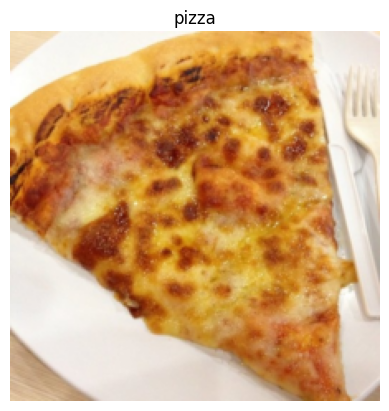

In [9]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

### 1.4 PatchEmbedding Layer

In [10]:
rand_image_tensor = torch.randn(32,3,224,224)
rand_image_tensor.shape

torch.Size([32, 3, 224, 224])

In [11]:
# 1. PatchEmbedding Class
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    Args:
    in_channels (int): Number of color channels for the input images. Defaults to 3.
    patch_size (int): Size of patches to convert input image into. Defaults to 16.
    embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class
    def __init__(self,
                 in_channels : int = 3,
                 patch_size : int = 16,
                 embedding_dim : int = 768):
        super().__init__()

        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embedding_dim = embedding_dim

        # 3. Layer to turn image into patches
        self.patcher = nn.Conv2d(in_channels = self.in_channels,
                                 out_channels = self.embedding_dim,
                                 kernel_size = self.patch_size,
                                 stride = patch_size,
                                 padding = 0)

        # 4. Layer to flatten the patch feature maps into a single dimension.
        self.flatten = nn.Flatten(start_dim = 2,
                                  end_dim = 3)

    # 5. Define the forward method
    def forward(self, x):
      # Create assertion to check that the inputs are in the correct shape
      image_resolution = x.shape[-1]
      assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape : {image_resolution}, patch_size : {self.patch_size}"

      # Perform the forward pass
      x_patched = self.patcher(x)
      x_flattened = self.flatten(x_patched)
      # 6. Make sure the output shape has the right order
      return x_flattened.permute(0, 2, 1)

In [12]:
patch_embedding = PatchEmbedding(patch_size = 16)
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"Input shape : {rand_image_tensor.shape}")
print(f"Output shape : {patch_embedding_output.shape} -> (batch_size, num_patches, embedding_dim)")

Input shape : torch.Size([32, 3, 224, 224])
Output shape : torch.Size([32, 196, 768]) -> (batch_size, num_patches, embedding_dim)


In [13]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 1.5 TransformerEncoderLayer
We can build a Transformer Encoder Layer with : https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer

In [14]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                                                       nhead = 12,
                                                       dim_feedforward = 3072,
                                                       dropout = 0.1,
                                                       activation= "gelu",
                                                       batch_first = True,
                                                       norm_first = True)
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [15]:
summary(model = transformer_encoder_layer,
        input_size = patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [32, 196, 768]            --
├─LayerNorm: 1-1                         [32, 196, 768]            1,536
├─MultiheadAttention: 1-2                [32, 196, 768]            2,362,368
├─Dropout: 1-3                           [32, 196, 768]            --
├─LayerNorm: 1-4                         [32, 196, 768]            1,536
├─Linear: 1-5                            [32, 196, 3072]           2,362,368
├─Dropout: 1-6                           [32, 196, 3072]           --
├─Linear: 1-7                            [32, 196, 768]            2,360,064
├─Dropout: 1-8                           [32, 196, 768]            --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 151.22
Input size (MB): 19.27
Forward/backward pass size (MB): 269.75
Params size (MB): 18.90
Estimated Total Size (MB): 307.92

### 1.6 Stack Transformer Encoder Layers on top of each other to make the full Transformer Encoder

According to Table 1 the ViT paper, the ViT model uses a stack of 12 Transformer Encoder Layers.

We can stack Transformer Encoder Layers on top of each other using : https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder

In [16]:
transformer_encoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer,
                                            num_layers=12)
transformer_encoder

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [17]:
summary(model = transformer_encoder, input_size = patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoder                       [32, 196, 768]            --
├─ModuleList: 1-1                        --                        --
│    └─TransformerEncoderLayer: 2-1      [32, 196, 768]            --
│    │    └─LayerNorm: 3-1               [32, 196, 768]            1,536
│    │    └─MultiheadAttention: 3-2      [32, 196, 768]            2,362,368
│    │    └─Dropout: 3-3                 [32, 196, 768]            --
│    │    └─LayerNorm: 3-4               [32, 196, 768]            1,536
│    │    └─Linear: 3-5                  [32, 196, 3072]           2,362,368
│    │    └─Dropout: 3-6                 [32, 196, 3072]           --
│    │    └─Linear: 3-7                  [32, 196, 768]            2,360,064
│    │    └─Dropout: 3-8                 [32, 196, 768]            --
│    └─TransformerEncoderLayer: 2-2      [32, 196, 768]            --
│    │    └─LayerNorm: 3-9               [32, 196, 768]   

### 1.7 Put it all together and create ViT


In [18]:
class ViT(nn.Module):
  def __init__(self,
               img_size = 224, # from table 3
               num_channels = 3,
               patch_size = 16,
               embedding_dim = 768,
               dropout = 0.1,
               mlp_size = 3072, # from table 1
               num_transformer_layers = 12, # from table 1
               num_heads = 12, # from table 1 (Number of multi-head self attention heads)
               num_classes = 1000): # Generic number of classes (can be adjusted)
    super().__init__()

    # Assert image size is divisble by patch_size
    assert img_size % patch_size == 0, f"Image size must be divisble by patch size, image size : {img_size}, patch size : {patch_size}"

    # 1. Create Patch Embedding
    self.patch_embedding = PatchEmbedding(in_channels = num_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)
    # 2. Create Class Token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad = True)
    # 3. Create Positional Embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = H*W / P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim),
                                             requires_grad = True)
    # 4. Create Patch + Positional Embedding Dropout
    self.embedding_dropout = nn.Dropout(p = dropout)
    # # 5. Create Transformer Encoder Layer
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = embedding_dim,
    #                                                             nhead = num_heads,
    #                                                             dim_feedforward = mlp_size,
    #                                                             activation = "gelu",
    #                                                             batch_first = True,
    #                                                             norm_first = True)
    # 5. Create stack Transformer Encoder Layers (stacked single layer)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(d_model = embedding_dim,
                                                                                                nhead = num_heads,
                                                                                                dim_feedforward = mlp_size,
                                                                                                activation = "gelu",
                                                                                                batch_first = True,
                                                                                                norm_first = True), # Create a single Transformer Encoder Layer
                                                      num_layers = num_transformer_layers) # Stack it N times
    # 6. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_dim),
        nn.Linear(in_features = embedding_dim,
                  out_features = num_classes)
    )
  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
  #  print(x.shape)

    # first expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # -1 means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim = 1)

   # print(x.shape)

    # Add positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    #print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder Stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0, :])
    return x


In [19]:
demo_img = torch.randn(1, 3, 224, 224).to(device)
#print(demo_img.shape)

# Create ViT
vit = ViT(num_classes=len(class_names)).to(device)
vit(demo_img)

tensor([[-0.6056,  0.1111,  0.1033]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [20]:
embedding_dim = 768
class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad = True)
class_token.requires_grad

True

In [21]:
PATCH_SIZE = 16
IMG_SIZE = 224

num_patches = (IMG_SIZE * IMG_SIZE) // PATCH_SIZE**2 # N = H*W / P^2
positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim),
                                        requires_grad = True)

positional_embedding.shape

torch.Size([1, 197, 768])

In [22]:
len(class_names)

3

In [23]:
summary(model = ViT(num_classes = 3),
        input_size = demo_img.shape)

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## 2. Turn the custom ViT architecture we created into a Python script, for example ViT.py


In [24]:
%%writefile vit.py

import torch
from torch import nn

# 1. PatchEmbedding Class
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    Args:
    in_channels (int): Number of color channels for the input images. Defaults to 3.
    patch_size (int): Size of patches to convert input image into. Defaults to 16.
    embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class
    def __init__(self,
                 in_channels : int = 3,
                 patch_size : int = 16,
                 embedding_dim : int = 768):
        super().__init__()

        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embedding_dim = embedding_dim

        # 3. Layer to turn image into patches
        self.patcher = nn.Conv2d(in_channels = self.in_channels,
                                 out_channels = self.embedding_dim,
                                 kernel_size = self.patch_size,
                                 stride = patch_size,
                                 padding = 0)

        # 4. Layer to flatten the patch feature maps into a single dimension.
        self.flatten = nn.Flatten(start_dim = 2,
                                  end_dim = 3)

    # 5. Define the forward method
    def forward(self, x):
      # Create assertion to check that the inputs are in the correct shape
      image_resolution = x.shape[-1]
      assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape : {image_resolution}, patch_size : {self.patch_size}"

      # Perform the forward pass
      x_patched = self.patcher(x)
      x_flattened = self.flatten(x_patched)
      # 6. Make sure the output shape has the right order
      return x_flattened.permute(0, 2, 1)


class ViT(nn.Module):
  def __init__(self,
               img_size = 224, # from table 3
               num_channels = 3,
               patch_size = 16,
               embedding_dim = 768,
               dropout = 0.1,
               mlp_size = 3072, # from table 1
               num_transformer_layers = 12, # from table 1
               num_heads = 12, # from table 1 (Number of multi-head self attention heads)
               num_classes = 1000): # Generic number of classes (can be adjusted)
    super().__init__()

    # Assert image size is divisble by patch_size
    assert img_size % patch_size == 0, f"Image size must be divisble by patch size, image size : {img_size}, patch size : {patch_size}"

    # 1. Create Patch Embedding
    self.patch_embedding = PatchEmbedding(in_channels = num_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)
    # 2. Create Class Token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad = True)
    # 3. Create Positional Embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = H*W / P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim),
                                             requires_grad = True)
    # 4. Create Patch + Positional Embedding Dropout
    self.embedding_dropout = nn.Dropout(p = dropout)
    # # 5. Create Transformer Encoder Layer
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = embedding_dim,
    #                                                             nhead = num_heads,
    #                                                             dim_feedforward = mlp_size,
    #                                                             activation = "gelu",
    #                                                             batch_first = True,
    #                                                             norm_first = True)
    # 5. Create stack Transformer Encoder Layers (stacked single layer)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(d_model = embedding_dim,
                                                                                                nhead = num_heads,
                                                                                                dim_feedforward = mlp_size,
                                                                                                activation = "gelu",
                                                                                                batch_first = True,
                                                                                                norm_first = True), # Create a single Transformer Encoder Layer
                                                      num_layers = num_transformer_layers) # Stack it N times
    # 6. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_dim),
        nn.Linear(in_features = embedding_dim,
                  out_features = num_classes)
    )
  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
  #  print(x.shape)

    # first expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # -1 means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim = 1)

   # print(x.shape)

    # Add positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    #print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder Stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0, :])
    return x


Overwriting vit.py


In [25]:
!python vit.py

In [26]:
from vit import ViT
imported_vit = ViT()
summary(model = imported_vit,
        input_size = (1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## 3. Training a pretrained ViT feature extractor model on 20% of the pizze, steak and sushi data

In [27]:
set_seeds()

In [28]:
# Create ViT feature extractor model
import torchvision

# Download pretrained ViT weights and model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available
pretrained_vit = torchvision.models.vit_b_16(weights = vit_weights).to(device)

# Freeze all layers in pretrained ViT model
for param in pretrained_vit.parameters():
  param.requires_grad = False

# Update the pretrained ViT head
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features = embedding_dim, out_features = len(class_names))
)
# Get a summary
summary(model = pretrained_vit,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [29]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

In [30]:
# Get 20% of data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need to test on 20 % will test on 10 %
# Preprocess the data
vit_transforms = vit_weights.transforms() # Get transforms from vit_weights
train_data_loader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir_20_percent,
                                                                                              test_dir = test_dir, # use 10% data for testing
                                                                                              batch_size = 64,
                                                                                              transform = vit_transforms)


[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [31]:
len(train_dataloader), len(train_data_loader_20_percent), len(test_dataloader)

(8, 8, 2)

In [32]:
# Train a pretrained ViT feature extractor
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params = pretrained_vit.parameters(),
                             lr = 1e-3)
loss = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model = pretrained_vit,
                                      train_dataloader = train_data_loader_20_percent,
                                      test_dataloader = test_dataloader,
                                      optimizer = optimizer,
                                      loss_fn = loss,
                                      epochs = 10,
                                      device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8528 | train_acc: 0.6445 | test_loss: 0.4298 | test_acc: 0.8778
Epoch: 2 | train_loss: 0.3149 | train_acc: 0.8691 | test_loss: 0.3733 | test_acc: 0.8935
Epoch: 3 | train_loss: 0.2189 | train_acc: 0.9414 | test_loss: 0.3108 | test_acc: 0.9013
Epoch: 4 | train_loss: 0.1405 | train_acc: 0.9570 | test_loss: 0.2233 | test_acc: 0.8857
Epoch: 5 | train_loss: 0.1336 | train_acc: 0.9609 | test_loss: 0.1921 | test_acc: 0.9766
Epoch: 6 | train_loss: 0.1713 | train_acc: 0.9004 | test_loss: 0.1634 | test_acc: 0.9609
Epoch: 7 | train_loss: 0.1028 | train_acc: 0.9648 | test_loss: 0.1477 | test_acc: 0.9609
Epoch: 8 | train_loss: 0.1524 | train_acc: 0.9082 | test_loss: 0.1648 | test_acc: 0.9609
Epoch: 9 | train_loss: 0.1341 | train_acc: 0.9141 | test_loss: 0.2304 | test_acc: 0.9389
Epoch: 10 | train_loss: 0.0818 | train_acc: 0.9805 | test_loss: 0.2085 | test_acc: 0.9389


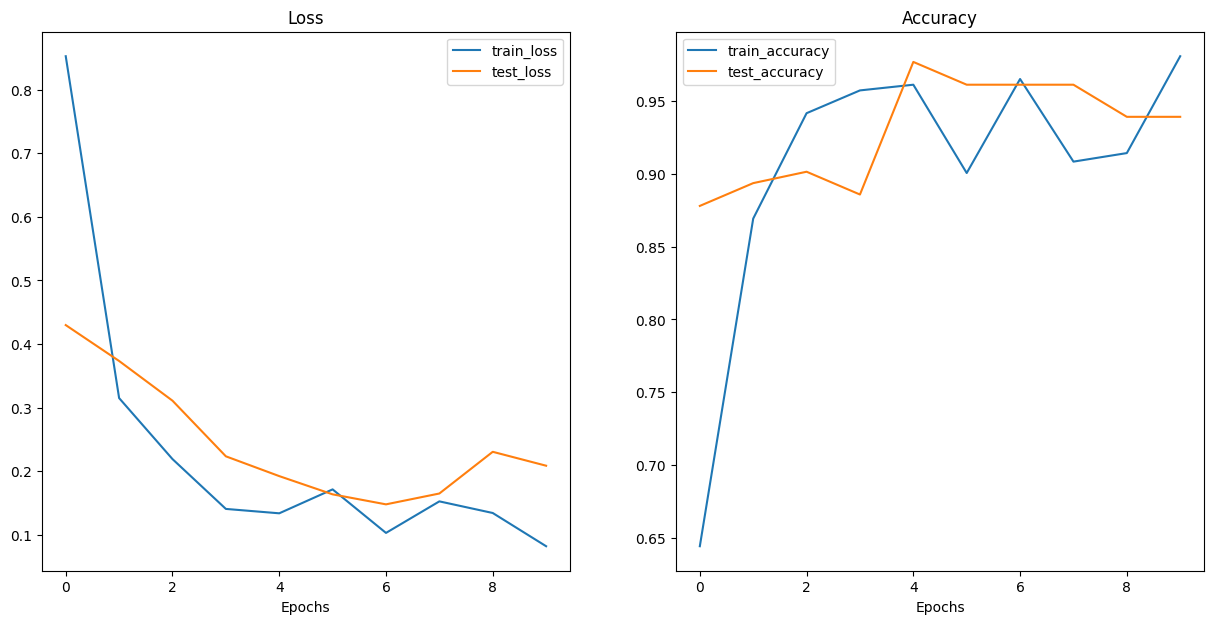

In [33]:
# Examine results
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

## 4. Repeatined step 3 but this time using "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights
* Note : ViT pretrained with SWAG weights has a minimum input image size of (384,384), though this is accessible in the weights `.transforms()` method.
https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16

In [34]:
# Create ViT feature extractor model
import torchvision

# Download pretrained ViT weights and model
vit_weights_swag = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 # Get Swag Weights
pretrained_vit_swag = torchvision.models.vit_b_16(weights = vit_weights_swag).to(device)

# Freeze all layers in pretrained ViT model
for param in pretrained_vit_swag.parameters():
  param.requires_grad = False

# Update the pretrained ViT head
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit_swag.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features = embedding_dim, out_features = len(class_names))
)
# Get a summary
summary(model = pretrained_vit_swag,
        input_size = (1, 3, 384, 384),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [35]:
# Transforms for pretrained ViT SWAG Weights
vit_transforms_swag = vit_weights_swag.transforms() # Get transforms from vit_weights_swag
vit_transforms_swag

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [36]:
# Get 20% of data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need to test on 20 % will test on 10 %

# Preprocess the data
train_data_loader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir_20_percent,
                                                                                           test_dir = test_dir, # use 10% data for testing
                                                                                           batch_size = 512,
                                                                                           transform = vit_transforms_swag)


[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [37]:
# Train a pretrained ViT feature extractor with SWAG Weights
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params = pretrained_vit_swag.parameters(),
                             lr = 1e-3)
loss = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_swag_results = engine.train(model = pretrained_vit_swag,
                                      train_dataloader = train_data_loader_20_percent,
                                      test_dataloader = test_dataloader,
                                      optimizer = optimizer,
                                      loss_fn = loss,
                                      epochs = 10,
                                      device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0201 | train_acc: 0.5022 | test_loss: 0.7611 | test_acc: 0.7867
Epoch: 2 | train_loss: 0.7643 | train_acc: 0.8156 | test_loss: 0.5627 | test_acc: 0.8933
Epoch: 3 | train_loss: 0.5686 | train_acc: 0.9022 | test_loss: 0.4185 | test_acc: 0.9600
Epoch: 4 | train_loss: 0.4263 | train_acc: 0.9578 | test_loss: 0.3159 | test_acc: 0.9733
Epoch: 5 | train_loss: 0.3247 | train_acc: 0.9711 | test_loss: 0.2436 | test_acc: 0.9733
Epoch: 6 | train_loss: 0.2525 | train_acc: 0.9800 | test_loss: 0.1928 | test_acc: 0.9867
Epoch: 7 | train_loss: 0.2011 | train_acc: 0.9822 | test_loss: 0.1569 | test_acc: 0.9867
Epoch: 8 | train_loss: 0.1643 | train_acc: 0.9822 | test_loss: 0.1313 | test_acc: 0.9867
Epoch: 9 | train_loss: 0.1376 | train_acc: 0.9822 | test_loss: 0.1128 | test_acc: 0.9867
Epoch: 10 | train_loss: 0.1179 | train_acc: 0.9822 | test_loss: 0.0992 | test_acc: 0.9867


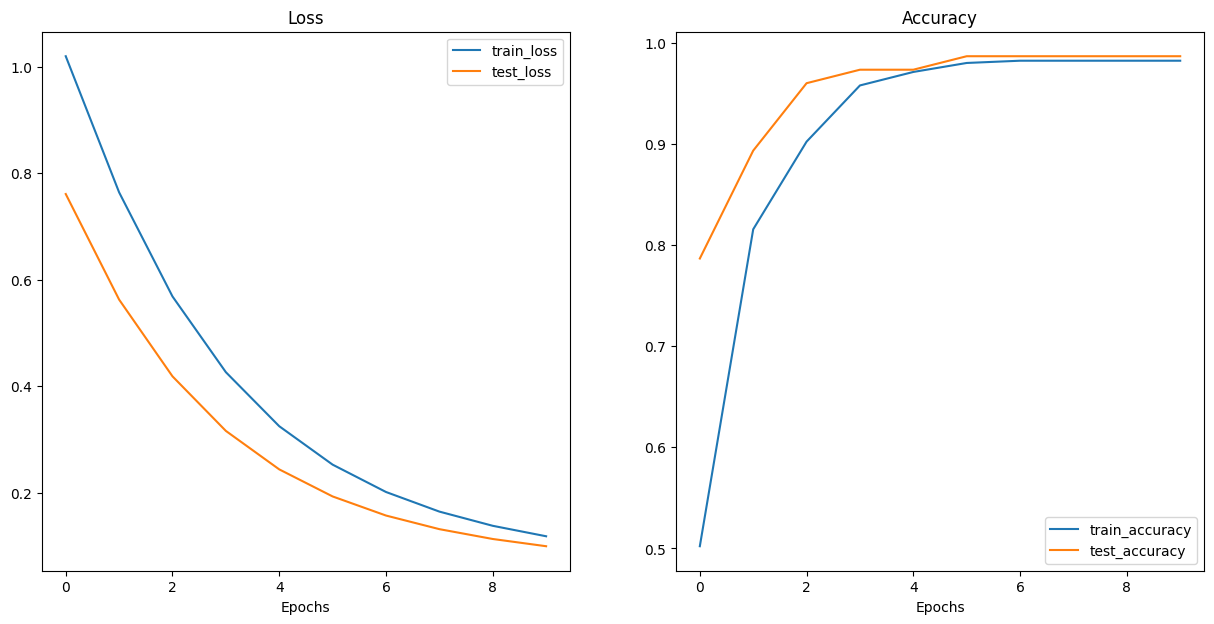

In [38]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_swag_results)

### Get the "Most Wrong" examples from the test dataset
Since our ViT model trained with SWAG weights performed so well on the test set(close to 99% accuracy), let's see which samples it actually got wrong

In [41]:
# Get all test data paths
from tqdm import tqdm
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function tp return a list of dictionaries with sample, label
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dic to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(dim = 0) # transform image
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim = 1)
      pred_label = torch.argmax(pred_prob, dim = 1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the cpu
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

    # Does the pred match the true labels?
    pred_dict["correct"] = class_name == pred_class

    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths = test_data_paths,
                                   model = pretrained_vit_swag,
                                   transform = vit_transforms_swag,
                                   class_names = class_names,
                                   device = device)


test_pred_dicts[:5]

100%|██████████| 75/75 [00:03<00:00, 22.28it/s]


[{'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/1987407.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9727989435195923,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2276986.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.7933695316314697,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/499605.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9705492854118347,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2521706.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9672814607620239,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9768378734588623,
  'pred_class': 'sushi',
  'correct': True}]

In [42]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)

# Sort DataFrame by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by = ["correct", "pred_prob"], ascending = [True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
57,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.587981,steak,False
71,data/pizza_steak_sushi/test/pizza/1687143.jpg,pizza,0.994338,pizza,True
55,data/pizza_steak_sushi/test/pizza/3475871.jpg,pizza,0.994295,pizza,True
66,data/pizza_steak_sushi/test/pizza/2111981.jpg,pizza,0.993817,pizza,True
50,data/pizza_steak_sushi/test/pizza/714866.jpg,pizza,0.993736,pizza,True


In [43]:
test_pred_df.correct.value_counts()

,count
correct,
True,74
False,1


/tmp/ipython-input-870358343.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
/tmp/ipython-input-870358343.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
/tmp/ipython-input-870358343.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = row[2]
/tmp/ipython-input-870358343.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, in

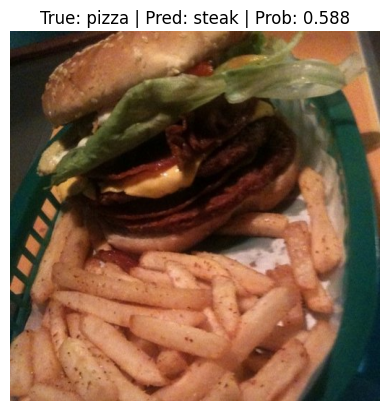

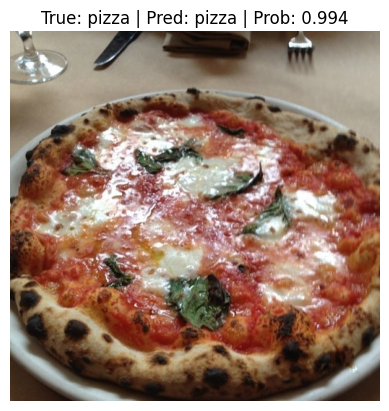

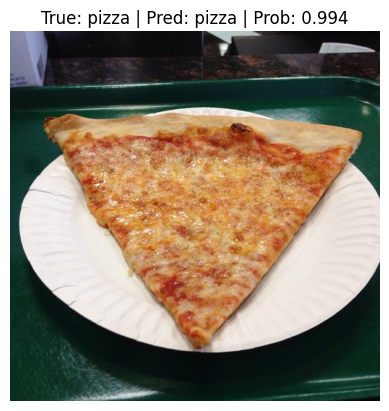

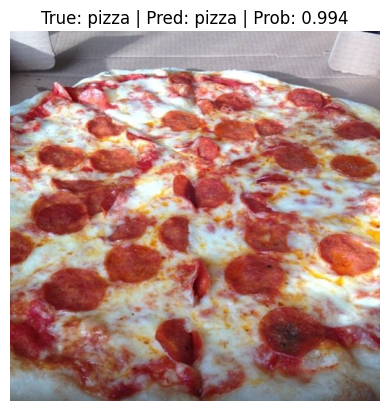

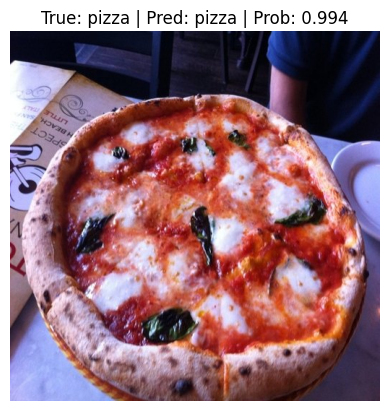

In [44]:
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  img = torchvision.io.read_image(str(image_path))
  plt.figure()
  plt.imshow(img.permute(1, 2, 0))
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);